## Building chatbot with multiple tools using langgraph

Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=5000)
arxiv= ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers.\n\n

In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki= WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [5]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [18]:
from langchain_tavily import TavilySearch
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv

load_dotenv()

# tavily = TavilySearch(
#     max_results=5,
#     topic="general",
#     # include_answer=False,
#     # include_raw_content=False,
#     # include_images=False,
#     # include_image_descriptions=False,
#     # search_depth="basic",
#     # time_range="day",
#     # include_domains=None,
#     # exclude_domains=None
# )

tavily = TavilySearchResults()

C:\Users\USER\AppData\Local\Temp\ipykernel_8724\1265755731.py:20: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [19]:
tavily.invoke({"query": "What happened at the last wimbledon"})

[{'title': 'Wimbledon 2025: Jannik Sinner comes from behind to dethrone ...',
  'url': 'https://www.olympics.com/en/news/wimbledon-2025-jannik-sinner-carlos-alcaraz-final-results',
  'content': 'The past two weeks of the Championships 2025 culminated in this grand finale, world No.1 Sinner against world No.2 Alcaraz on Centre Court. A cool British summer’s afternoon called for some tantalising tennis, and the Italian and Spanish stars respectively were here to serve up a treat. [...] The Italian tennis titan stretched his arms out to the sky as he was crowned men’s singles champion of Wimbledon 2025, dethroning two-time reigning champion and world No.2 Carlos Alcaraz 4-6, 6-4, 6-4, 6-4 on Sunday (13 July). [...] From February to May 2025, Sinner served a doping ban in a settlement with the World Anti-Doping Agency. Now, just 35 days after the respective world No.1 and No.2 players played out a five-and-a-half-hour classic in the Roland-Garros final, Sinner has exacted his revenge with 

In [20]:
# Combine tools in a list

tools = [arxiv, wiki, tavily]

In [23]:
from langchain.chat_models import init_chat_model

llm= init_chat_model("groq:openai/gpt-oss-20b")

llm_with_tools = llm.bind_tools(tools)

In [25]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

llm_with_tools.invoke([HumanMessage(content="What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'fc_b515a9a0-f334-4c4b-a2e6-db8c5721d51a',
  'type': 'tool_call'}]

In [26]:
from typing import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

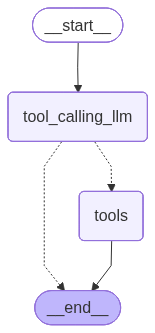

In [28]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


# Node definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Building Graph
builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges( # if the latest message from the tool_calling_llm(assistant) is a tool call  -> toold condition rooutes to tools otherwise routes top end
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)


graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
messages = graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (fc_64af0f09-2bd9-49c2-9ac2-6340c6ee788b)
 Call ID: fc_64af0f09-2bd9-49c2-9ac2-6340c6ee788b
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, based
solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Ex

In [31]:
messages = graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (fc_8b03e5ad-91e8-4ed1-b899-0f57c6eee4ab)
 Call ID: fc_8b03e5ad-91e8-4ed1-b899-0f57c6eee4ab
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
